In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = "D:\\Bootcamp\\MIMIC IV\\"
admissions = pd.read_csv(path + "core\\admissions.csv.gz", compression='gzip')
patients = pd.read_csv(path + "core\\patients.csv.gz", compression='gzip')
transfers = pd.read_csv(path + "core\\transfers.csv.gz", compression='gzip')

diagnoses = pd.read_csv(path + "hosp\\diagnoses_icd.csv.gz", compression='gzip')
d_diagnoses = pd.read_csv(path + "hosp\\d_icd_diagnoses.csv.gz", compression='gzip')
drg_codes = pd.read_csv(path + "hosp\\drgcodes.csv.gz", compression='gzip')

In [3]:
drg_codes = pd.read_csv(path + "hosp\\drgcodes.csv.gz", compression='gzip')

# Predict Future Diagnoses

Feasbility study to see if we can predict whether a patient will develop a disease (initially CHF) from their patient history leading up to (but not including) their first diagnosis. 

### Outline

1. Identify CHF patients
1. Look at patient histories
1. Look at co-morbidities
1. Identify first CHF diagnosis
1. Identify visit right before CHF diagnosis (< 1 mo)
1. Look for features to predict pre-CHF state (lab tests in history)

In [4]:
pos_codes = d_diagnoses[(d_diagnoses['long_title'].str.lower().str.contains('congestive',)) & (d_diagnoses['long_title'].str.lower().str.contains('heart'))]
pos_codes

,icd_code,icd_version,long_title
4620,39891,9,Rheumatic heart failure (congestive)
4793,4280,9,"Congestive heart failure, unspecified"
22226,I5020,10,Unspecified systolic (congestive) heart failure
22227,I5021,10,Acute systolic (congestive) heart failure
22228,I5022,10,Chronic systolic (congestive) heart failure
22229,I5023,10,Acute on chronic systolic (congestive) heart f...
22230,I5030,10,Unspecified diastolic (congestive) heart failure
22231,I5031,10,Acute diastolic (congestive) heart failure
22232,I5032,10,Chronic diastolic (congestive) heart failure
22233,I5033,10,Acute on chronic diastolic (congestive) heart ...


In [5]:
pos_diagnoses = diagnoses[diagnoses['icd_code'].isin(pos_codes.icd_code)]
admissions['pos_subj'] = np.where(admissions.subject_id.isin(pos_diagnoses.subject_id), 1, 0)
admissions['pos_adm'] = np.where(admissions.hadm_id.isin(pos_diagnoses.hadm_id), 1, 0)

admissions['admittime'] = pd.to_datetime(admissions.admittime)
admissions = admissions.sort_values('admittime')
admissions['dischtime'] = pd.to_datetime(admissions.dischtime)
admissions['hadm_time'] = admissions.dischtime - admissions.admittime

admissions = admissions.rename(columns={'hospital_expire_flag':'expire_flag'})

In [6]:
primary_drg = drg_codes.drop('drg_code', axis=1).rename(columns={'description':'drg_code'})
primary_drg = primary_drg[['subject_id', 'hadm_id', 'drg_code']].drop_duplicates()
primary_drg = primary_drg.groupby('hadm_id').first().reset_index()
primary_drg.head()

,hadm_id,subject_id,drg_code
0,20000019,10467237,SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ HOURS W...
1,20000024,16925328,RED BLOOD CELL DISORDERS W/O MCC
2,20000041,18910522,Knee Joint Replacement
3,20000055,11868001,"Neonate, Bwt > 2499g, Normal Newborn Or Neonat..."
4,20000069,14546051,Vaginal Delivery


In [7]:
primary_icd = diagnoses[diagnoses['seq_num']==1].merge(d_diagnoses, how='left', on=['icd_version', 'icd_code'])
primary_icd = primary_icd.drop('icd_code', axis=1).rename(columns={'long_title':'icd_code'})
primary_icd = primary_icd[['subject_id', 'hadm_id', 'icd_code']].drop_duplicates()
primary_icd = primary_icd.groupby('hadm_id').first().reset_index()
primary_icd.head()

,hadm_id,subject_id,icd_code
0,20000019,10467237,Unspecified septicemia
1,20000024,16925328,Iron deficiency anemia secondary to blood loss...
2,20000034,19430048,Obstruction of bile duct
3,20000041,18910522,"Osteoarthrosis, localized, not specified wheth..."
4,20000055,11868001,"Single liveborn, born in hospital, delivered b..."


In [8]:
admissions = admissions.merge(primary_drg, how='left').merge(primary_icd, how='left')
admissions.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,expire_flag,pos_subj,pos_adm,hadm_time,drg_code,icd_code
0,16904137,21081215,2105-10-04 17:26:00,2105-10-12 11:11:00,NaN,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,MARRIED,OTHER,NaN,NaN,0,0,0,7 days 17:45:00,NaN,NaN
1,12024697,20302177,2109-12-14 22:50:00,2110-01-15 14:53:00,NaN,EW EMER.,EMERGENCY ROOM,REHAB,Other,ENGLISH,MARRIED,WHITE,2109-12-14 19:31:00,2109-12-15 01:56:00,0,0,0,31 days 16:03:00,NaN,NaN
2,13308789,22079847,2110-01-11 00:57:00,2110-01-13 12:45:00,NaN,ELECTIVE,NaN,HOME,Other,ENGLISH,NaN,BLACK/AFRICAN AMERICAN,NaN,NaN,0,0,0,2 days 11:48:00,"Neonate, Bwt > 2499g, Normal Newborn Or Neonat...","Single liveborn, born in hospital, delivered w..."
3,15350437,20383396,2110-01-11 08:02:00,2110-01-12 18:45:00,NaN,EU OBSERVATION,TRANSFER FROM HOSPITAL,NaN,Other,ENGLISH,SINGLE,WHITE,2110-01-11 03:43:00,2110-01-11 08:41:00,0,0,0,1 days 10:43:00,NaN,"Sixth [abducent] nerve palsy, bilateral"
4,14742657,29081685,2110-01-11 09:53:00,2110-01-13 13:00:00,NaN,ELECTIVE,NaN,HOME,Other,ENGLISH,NaN,UNABLE TO OBTAIN,NaN,NaN,0,0,0,2 days 03:07:00,NaN,NaN


In [9]:
admissions.shape

(524520, 20)

# Move to EDA Notebook >>>>>>>>>>>>>>

In [10]:
admissions.groupby('ethnicity').agg({'pos_subj':['count', 'mean']})

pos_subj          
                                 count      mean
ethnicity                                       
AMERICAN INDIAN/ALASKA NATIVE     1536  0.152995
ASIAN                            24522  0.084210
BLACK/AFRICAN AMERICAN           80526  0.220997
HISPANIC/LATINO                  29887  0.164520
OTHER                            26844  0.122634
UNABLE TO OBTAIN                  3742  0.068145
UNKNOWN                          19419  0.099078
WHITE                           338044  0.196679

In [11]:
pos_index = admissions.groupby('subject_id').agg(pos_subj=('pos_subj', 'max'))
print(np.sum(pos_index))
print(np.mean(pos_index))

pos_subj    21137
dtype: int64
pos_subj    0.082128
dtype: float64


In [12]:
result = admissions.groupby('pos_subj').agg(total_adm=('hadm_id','count'),
                                             adm_fraction=('hadm_id', lambda x: len(x)/524520),
                                             death_count=('expire_flag', 'sum'),
                                             death_fraction=('expire_flag', 'mean'))
result['chance_of_death'] = result.death_fraction/result.adm_fraction
# ^^^ DOUBLE CHECK THIS LINE FOR BAYSIAN PROBABILITY ^^^
result

,total_adm,adm_fraction,death_count,death_fraction,chance_of_death
pos_subj,,,,,
0,427550,0.815126,6592,0.015418,0.018915
1,96970,0.184874,2777,0.028638,0.154904


In [13]:
admissions.expire_flag.sum()/admissions.subject_id.nunique()

0.03640340992982756

In [14]:
admissions[admissions.pos_subj == 1].expire_flag.sum()/admissions[admissions.pos_subj == 1].subject_id.nunique()

0.1313809906798505

In [15]:
# how long on avg does it take for someone to die with CHF

# <<<<<<<<<<<<<<<<<

In [22]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [17]:
pd.set_option('display.width', 1000)

In [18]:
rows = ['subject_id', 'admittime', 'pos_adm', 'expire_flag', 'drg_code', 'icd_code']
sample_adm = admissions[admissions.pos_subj==1][rows]
sample_adm['admittime'] = sample_adm.admittime.dt.date
for subj in sample_adm.sample(100).subject_id.unique():
    print('Subject: ', subj)
    print('-'*80)
    print(sample_adm[sample_adm.subject_id==subj][rows], '\n')

Subject:  17925055
--------------------------------------------------------------------------------
        subject_id   admittime  pos_adm  expire_flag                                           drg_code                                           icd_code
161049    17925055  2139-01-30        1            0  PERC CARDIOVASC PROC W DRUG-ELUTING STENT W/O MCC  Subendocardial infarction, initial episode of ...
218228    17925055  2147-08-23        0            0                           Major Bladder Procedures            Malignant neoplasm of left renal pelvis 

Subject:  10275673
--------------------------------------------------------------------------------
        subject_id   admittime  pos_adm  expire_flag                                           drg_code                                           icd_code
237728    10275673  2150-08-20        0            0  Respiratory System Signs, Symptoms & Other Dia...                                          Hypoxemia
269652    10275673  215

401872    13714286  2175-10-31        0            0     Septicemia & Disseminated Infections                         Other Gram-negative sepsis 

Subject:  11098660
--------------------------------------------------------------------------------
        subject_id   admittime  pos_adm  expire_flag                                           drg_code                                           icd_code
288405    11098660  2158-06-25        0            0               Major Small & Large Bowel Procedures            Diverticulosis of colon with hemorrhage
296962    11098660  2159-10-24        0            0                                                NaN  Diverticulosis of colon (without mention of he...
297872    11098660  2159-12-12        1            0                        HEART FAILURE & SHOCK W MCC           Acute on chronic diastolic heart failure
298475    11098660  2160-01-15        1            0  Cardiac Catheterization w/ Circ Disord Exc Isc...           Acute on chronic di

        subject_id   admittime  pos_adm  expire_flag                                           drg_code                                           icd_code
233124    14867101  2149-11-30        0            0                                                NaN                                                NaN
233691    14867101  2149-12-31        0            0                                                NaN                                                NaN
233793    14867101  2150-01-05        0            0                                                NaN                                                NaN
234858    14867101  2150-03-06        0            0                                                NaN                                                NaN
235023    14867101  2150-03-15        0            0                                                NaN                                                NaN
235171    14867101  2150-03-24        0            0                  

511701    18524648  2196-08-17        1            0  MISC DISORDERS OF NUTRITION,METABOLISM,FLUIDS/...                                    Hyperpotassemia 



In [147]:
# find patients who have a negative visit right before a positive visit

first_admissions = admissions.iloc[admissions[admissions.pos_subj==1].groupby('subject_id').admittime.idxmin()]
subj_list = first_admissions[first_admissions.pos_adm==0].subject_id.unique()
print('There are', admissions[admissions.pos_subj==1].subject_id.nunique(), 'subjects with CHF, and',
      len(subj_list), 'subjects with CHF that had at a negative visit before CHF diagnosis.')

There are 21137 subj_list with CHF, and 9506 subjects with CHF that had at least one visit before CHF diagnosis.


In [163]:
# create dataframes for first positive visits and most recent previous visits

# create refernce dataframe
subj_admissions = admissions[admissions.subject_id.isin(subj_list)]
subj_admissions = subj_admissions.sort_values(['subject_id', 'admittime']).reset_index(drop=True)
pos_adm = subj_admissions[['subject_id', 'hadm_id', 'admittime', 'pos_adm']]
pos_adm = pos_adm.loc[pos_adm[pos_adm.pos_adm==1].groupby('subject_id').admittime.idxmin()]
pos_adm = pos_adm.rename(columns={'pos_adm':'first_pos'}).drop('admittime', axis=1)
subj_admissions = subj_admissions.merge(pos_adm, how='left')

# slice based on first visit/prior visit
first_idx = subj_admissions[subj_admissions.first_pos==1].index
pos_adm = subj_admissions.iloc[first_idx].reset_index(drop=True)
prev_adm = subj_admissions.iloc[first_idx-1].reset_index(drop=True)

#sanity checks
print('Positive cases in previous visit: ', prev_adm.pos_adm.sum())
print('Mismatched patient count: ', np.sum(pos_adm['subject_id'] - prev_adm['subject_id']))

Positive cases in previous visit:  0
Mismatched patient count:  0


In [239]:
prev_adm['time_delta'] = pos_adm.admittime - prev_adm.dischtime
prev_adm.time_delta.describe()

count                        9506
mean     591 days 11:42:02.682516
std      755 days 10:33:05.949361
min               0 days 00:00:00
25%              54 days 03:16:00
50%             286 days 21:10:30
75%             825 days 22:23:15
max            4329 days 05:22:00
Name: time_delta, dtype: object

In [240]:
370//365

1

Text(0, 0.5, 'Number of Patients')

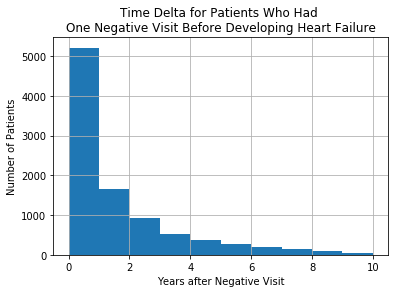

In [241]:
prev_adm['time_delta'].apply(lambda x: x.days/365).hist(bins=10, range=(0,10))
plt.title('Time Delta for Patients Who Had \nOne Negative Visit Before Developing Heart Failure')
plt.xlabel('Years after Negative Visit')
plt.ylabel('Number of Patients')

Text(0, 0.5, 'Number of Patients')

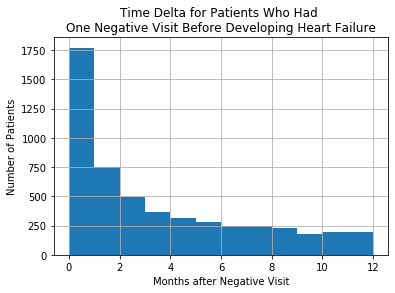

In [242]:
prev_adm['time_delta'].apply(lambda x: x.days/31).hist(bins=12, range=(0,12))
plt.title('Time Delta for Patients Who Had \nOne Negative Visit Before Developing Heart Failure')
plt.xlabel('Months after Negative Visit')
plt.ylabel('Number of Patients')

In [245]:
# select group of interest (< 1 year before diagnosis)

prev_adm1 = prev_adm[prev_adm.time_delta < pd.to_timedelta('365 days')]
prev_adm1.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,...,edouttime,expire_flag,pos_subj,pos_adm,hadm_time,drg_code,icd_code,first_pos,pos_delta,time_delta
4,10002428,20321825,2156-04-30 20:35:00,2156-05-03 16:36:00,NaN,EW EMER.,EMERGENCY ROOM,CHRONIC/LONG TERM ACUTE CARE,Medicare,ENGLISH,...,2156-04-30 21:53:00,0,1,0,2 days 20:01:00,Pulmonary Edema & Respiratory Failure,Acute respiratory failure,NaN,7 days 22:13:00,7 days 22:13:00
5,10002430,27218502,2125-06-23 09:00:00,2125-06-25 11:42:00,NaN,URGENT,PHYSICIAN REFERRAL,HOME HEALTH CARE,Medicare,ENGLISH,...,NaN,0,1,0,2 days 02:42:00,"Inguinal, Femoral & Umbilical Hernia Procedures","Unilateral inguinal hernia, with obstruction, ...",NaN,95 days 06:05:00,95 days 06:05:00
7,10003400,29483621,2136-11-04 20:43:00,2136-11-12 17:40:00,NaN,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,ENGLISH,...,2136-11-04 22:12:00,0,1,0,7 days 20:57:00,Digestive Malignancy,"Malignant neoplasm of other sites of rectum, r...",NaN,26 days 21:04:00,26 days 21:04:00
8,10003502,29391916,2165-12-24 04:45:00,2165-12-26 14:15:00,NaN,EU OBSERVATION,EMERGENCY ROOM,NaN,Medicare,?,...,2165-12-24 06:41:00,0,1,0,2 days 09:30:00,NaN,Atrial flutter,NaN,50 days 22:51:00,50 days 22:51:00
9,10003637,23487925,2146-01-22 23:08:00,2146-01-26 14:02:00,NaN,OBSERVATION ADMIT,EMERGENCY ROOM,HOME HEALTH CARE,Other,ENGLISH,...,2146-01-23 00:33:00,0,1,0,3 days 14:54:00,Minor Small & Large Bowel Procedures,Rectal abscess,NaN,23 days 02:47:00,23 days 02:47:00


In [263]:
# look for labs from visit right before CHF

# load lab tests
lab_events_final = pd.read_pickle("lab_events_final.pkl")
lab_events = lab_events_final[lab_events_final.subject_id.isin(prev_adm1.subject_id)]
lab_events.shape

(256628, 15)

In [252]:
prev_adm1.shape

5210

In [262]:
print('There are %i target patients who had one negative hospital visit within one year of heart failure' % prev_adm1.shape[0])
print('On average, they had %i days before the diagnosis of heart failure' % prev_adm1.time_delta.dt.days.mean())
print('For the lab tests, there are %i patients without any lab tests' % (prev_adm1.shape[0] - lab_events_final.subject_id.nunique()))
print('For those with lab tests, there were %.1f tests run per patient' % (lab_events_final[lab_events_final.subject_id.isin(prev_adm1.subject_id)].shape[0]/prev_adm1.shape[0]))

There are 5210 target patients who had one negative hospital visit within one year of heart failure
On average, they had 106 days before the diagnosis of heart failure
For the lab tests, there are 436 patients without any lab tests
For those with lab tests, there were 49.3 tests run per patient


In [264]:
lab_events.head()

,labevent_id,subject_id,hadm_id,specimen_id,itemid,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
490812,36295136,12935402,21888842.0,42068067,50947,2165-01-03 14:45:00,2165-01-03 15:51:00,1,1.0,NaN,NaN,NaN,NaN,STAT,NaN
557907,36294536,12935402,NaN,20021501,51277,2160-01-01 09:10:00,2160-01-01 14:18:00,14.0,14.0,%,10.5,15.5,NaN,ROUTINE,NaN
558271,36293958,12935402,NaN,49255662,51237,2156-06-11 08:35:00,2156-06-11 17:03:00,3.4,3.4,NaN,0.9,1.1,abnormal,ROUTINE,NaN
558272,36293959,12935402,NaN,49255662,51274,2156-06-11 08:35:00,2156-06-11 17:03:00,33.0,33.0,sec,10.4,13.4,abnormal,ROUTINE,NaN
558273,36293960,12935402,NaN,68903004,51237,2156-07-04 10:40:00,2156-07-04 16:12:00,3.1,3.1,NaN,0.9,1.1,abnormal,ROUTINE,NaN
